# Phenotype classification  with logistic regression
In order to predict phenotypes from expression data and select important developmental genes a multi-target/multi-label classification method was used: logistic regression based binary relevance classifier.  Binary relevance constructs a model for each target separately and then predicts the final label set as a union of predictions from target feature specific models. To perform feature (gene) selection l1 regularisation was used.

In [15]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
#from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
from skmultilearn.model_selection import IterativeStratification
import sklearn.preprocessing as pp
import altair as alt
#alt.renderers.enable('notebook')
from IPython.display import display
import matplotlib.pyplot as plt

import stages_DE.stages_library
import importlib
importlib.reload(stages_DE.stages_library)

from networks.functionsDENet import loadPickle,savePickle
from stages_DE.stages_library import PHENOTYPES, summary_classification, summary_classification_print_sort, scatter_catgory


In [16]:
proteus=True
if proteus:
    pathClassification = '/home/khrovatin/timeTrajectoriesNet/data/stages/classification/'
    dataPath= '/home/khrovatin/timeTrajectoriesNet/data/RPKUM/'
else:
    pathClassification = '/home/karin/Documents/timeTrajectories/data/stages/classification/'

## Data summary statistics

In [3]:
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [5]:
print('N all samples: ',conditions.shape[0])
print('N samples with phenotypic annotation:',(conditions[PHENOTYPES] != 0).any(axis=1).sum())
print('N all WT samples: ',conditions.query('Group =="WT"').shape[0])
print('N WT samples with phenotypic annotation:',(conditions.query('Group =="WT"')[PHENOTYPES] != 0).any(axis=1).sum())

N all samples:  486
N samples with phenotypic annotation: 344
N all WT samples:  112
N WT samples with phenotypic annotation: 69


Samples that have annotations include samples with images and samples at t=0, as those are all no_agg. WT samples are AX4 and MybBGFP. Henceforth only samples that have annotations will be used. 

In [67]:
# retain samples that have a phenotypic annotation
Y = conditions[(conditions[PHENOTYPES] != 0).any(axis=1)]
X = genes[Y.Measurment].T.values
Y_WT = conditions.query('Group =="WT"')[(conditions.query('Group =="WT"')[PHENOTYPES] != 0).any(axis=1)]
X_WT = genes[Y_WT.Measurment].T.values

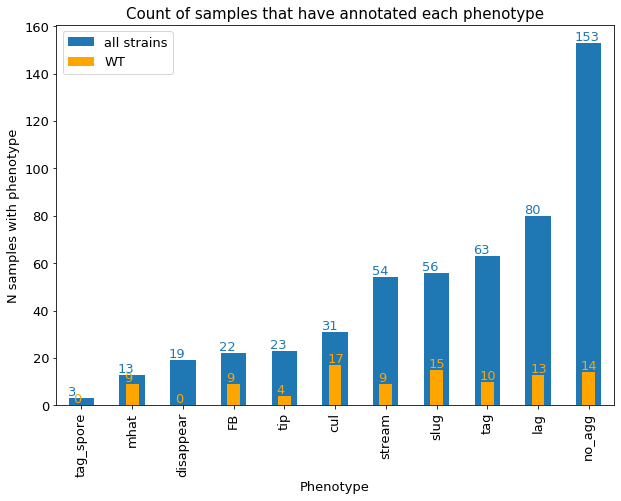

In [69]:
plot_data=Y[PHENOTYPES].sum().sort_values().astype('int')
ax = plot_data.plot(kind='bar', figsize=(10,7), fontsize=13,label='all strains')
#This must be sored as 'all' else the mapping to X labels is wrong
plot_data_WT=Y_WT[PHENOTYPES].astype('int').sum().loc[plot_data.index]
ax.bar(plot_data_WT.index, plot_data_WT.values, 
       color = 'orange', width = 0.25,label='WT')
ax.legend(fontsize=13)
for i in ax.patches:
     ax.text(i.get_x()-.03, i.get_height()+1, str(i.get_height()), fontsize=13,color=i.get_facecolor())
ax.set_xlabel('Phenotype', fontsize=13)
ax.set_ylabel('N samples with phenotype', fontsize=13)
a=ax.set_title('Count of samples that have annotated each phenotype', fontsize=15)


tag_spore has too little samples to be predicted. Nevertheless, samples with tag_spore annotation among their annotations can still be used. Some samples will thus have 0 labels in all targets.  Similarly, for WT stages tag_spore, disappera, and tip would need to be removed.

In [70]:
# Remove targets (Phenoptypes) with too little samples
order=PHENOTYPES.copy()
order.remove('tag_spore')
Y = Y[order].values

order_WT=[phenotype for phenotype in PHENOTYPES if phenotype not in ['tag_spore','tip','disappear']]
Y_WT = Y_WT[order_WT].values

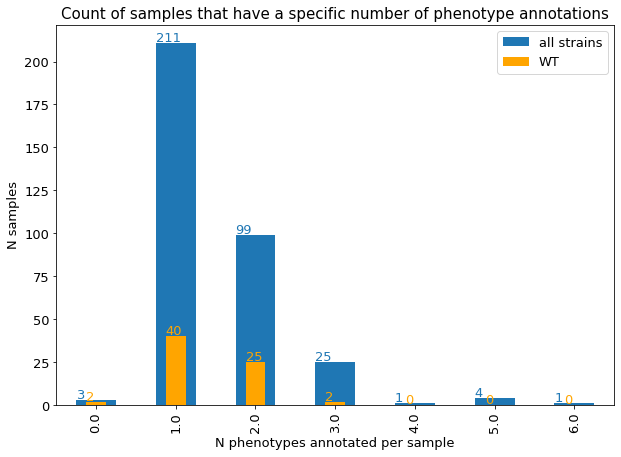

In [71]:
plot_data=pd.DataFrame(pd.DataFrame(Y).sum(axis=1)).groupby(0).size()
ax = plot_data.plot(
    kind='bar', figsize=(10,7), fontsize=13,label='all strains')
# Reindex to match X order of plot_data else the mapping to X labels would be wrong
plot_data_WT=pd.DataFrame(pd.DataFrame(Y_WT).sum(axis=1)).groupby(0).size().reindex(index=plot_data.index).fillna(0).astype('int')
ax.bar(plot_data_WT.index, plot_data_WT.values, 
       color = 'orange', width = 0.25,label='WT')
ax.legend(fontsize=13)
for i in ax.patches:
     ax.text(i.get_x(), i.get_height()+1, str(i.get_height()), fontsize=13,color=i.get_facecolor())
ax.set_xlabel('N phenotypes annotated per sample', fontsize=13)
ax.set_ylabel('N samples', fontsize=13)
a=ax.set_title('Count of samples that have a specific number of phenotype annotations', fontsize=15)

In [72]:
print('N features (genes):',X.shape[1])
print('N constant features:',(X.std(axis=0)==0).sum())
print('N WT features (genes):',X_WT.shape[1])
print('N constant WT features:',(X_WT.std(axis=0)==0).sum())

N features (genes): 12828
N constant features: 400
N WT features (genes): 12828
N constant WT features: 505


## Model fitting and performance statistic calculation
Models (with and without regularisation) are fit using five-fold cross validation. Saved metrics: F_score, precision, recall, and N used features (and micro averaged ROC_AUC score).

In [141]:
# Which data to model (WT or all strains)
X_model=X_WT.copy()
Y_model=Y_WT.copy()
order_model=order_WT.copy()
# Remove constant features
X_model=X_model[:,(X_model.std(axis=0)!=0)]
print(Y_model.shape,X_model.shape,len(order_model))

(69, 8) (69, 12323) 8


In [ ]:
prfs_all=pd.DataFrame()
rac_all=pd.DataFrame()
feats_all=pd.DataFrame()
split = IterativeStratification(n_splits=5, order=1)
fold=0
                
# Cross validation
for train_index, test_index in split.split(X_model, Y_model):
    fold += 1
    print(fold)
    scaler = pp.MinMaxScaler()
    #Scale X features to [0,1], use X_train_fold scaller to also scale X_test_fold
    X_train_fold, X_test_fold = X_model[train_index], X_model[test_index]
    Y_train_fold, Y_test_fold = Y_model[train_index], Y_model[test_index]
    X_train_fold=scaler.fit_transform(X_train_fold)
    X_test_fold=scaler.transform(X_test_fold)
    # Different regularization strengths - none or 1 
    for params in [
        {'penalty':'none','class_weight':'balanced'}
        ,{'penalty':'none'}
                   ,{'penalty':'l1','C':0.8,'class_weight':'balanced'}
        ,{'penalty':'l1','C':0.9}
                  ]:
        c=''
        for param_value in params.values():
            c=c+str(param_value)+'_'
        c=c.rstrip('_')
        print('C:',c)
        classifier = OneVsRestClassifier(
            # saga is only solver that supports no penaly and penalty = l1. 
            estimator=LogisticRegression( n_jobs=20,  solver='saga',**params),
            n_jobs=Y_model.shape[1]).fit(X_train_fold,Y_train_fold)
        
        # Quality metrics for the model
        Y_predict_fold = classifier.predict(X_test_fold)
        Y_p_fold = classifier.predict_proba(X_test_fold)
        
        prfs=pd.DataFrame(precision_recall_fscore_support(Y_test_fold, Y_predict_fold),index=['precision','recall','F_score','support']).T
        prfs['Group']=order_model
        prfs['params']=[c]*prfs.shape[0]
        prfs_all=prfs_all.append(prfs)
        prfs=list(precision_recall_fscore_support(Y_test_fold, Y_predict_fold, average='micro'))
        prfs.extend(['micro',c])
        prfs=dict(zip(['precision','recall','F_score','support','Group',"params"],prfs))
        prfs_all = prfs_all.append( prfs,ignore_index=True)
        prfs=list(precision_recall_fscore_support(Y_test_fold, Y_predict_fold, average='macro'))
        prfs.extend(['macro',c])
        prfs=dict(zip(['precision','recall','F_score','support','Group',"params"],prfs))
        prfs_all = prfs_all.append( prfs,ignore_index=True)
        
        rac=pd.DataFrame(roc_auc_score(Y_test_fold, Y_p_fold,average=None),columns=['roc_auc'])
        rac['Group']=order_model
        rac['params']=[c]*rac.shape[0]
        rac_all = rac_all.append(rac,ignore_index=True)
        rac=dict(zip(['roc_auc','Group','params'],[roc_auc_score(Y_test_fold, Y_p_fold, average='micro'),'micro',c]))
        rac_all=rac_all.append(rac,ignore_index=True)
        rac=dict(zip(['roc_auc','Group','params'],[roc_auc_score(Y_test_fold, Y_p_fold, average='macro'),'macro',c]))
        rac_all=rac_all.append(rac,ignore_index=True)
        
        # N used features in the model
        feats_combined = set()
        for i in range(len(order_model)):
            cl = classifier.estimators_[i]
            feats_stage = set(pd.Series(range(X_model.shape[1]))[(cl.coef_ != 0).flatten()[:X_model.shape[1]]].index)
            feats_combined = feats_combined | feats_stage
            #print(len(feats_stage), len(feats_combined))
            feats=dict(zip(['N_features','params','Group'],[len(feats_stage),c,order_model[i]]))
            feats_all=feats_all.append(feats,ignore_index=True)
        feats= dict(zip(['N_features', 'params', 'Group'],[len(feats_combined), c, 'all']))
        feats_all = feats_all.append(feats,ignore_index=True)
savePickle(pathClassification+'logisticRegressionBinaryRelevanceComparisonWT.pkl',{'prfs':prfs_all,'rac':rac_all,'featsN':feats_all})

## Model performance

Model names component: l1_C - l1 regularization with regularization constant (C) writted anfter underscore, none - no regularisation, balanced - balanced weights for labels (0,1) within targets/phenotypes. 
Summary statistics averages: micro - over all samples, macro - over pre-calculated statistics of all target features.

In [17]:
result=loadPickle(pathClassification+'logisticRegressionBinaryRelevanceComparison.pkl')

F score is a harmonic mean of precision (true predicted positives/all predicted positives) and recall (true predicted positives/all true positives). 

In [18]:
data_prfs=result['prfs'].groupby('params')
#for group in ['none','none_balanced','l1_0.6_balanced']:
for group in ['none_balanced','l1_0.6_balanced']:
    data=data_prfs.get_group(group)
    summary=summary_classification(data,'F_score',"Group",print_df=False)
    print('F score summary for OvR logistic regression:',group)
    summary_classification_print_sort(summary,statistic='F score',averages=['macro','micro'],groups=order)
    print('\n')


F score summary for OvR logistic regression: none_balanced
Mean cross validation F score averaged across all phenotypes and standard error
macro       0.71  +- 0.01
micro       0.75  +- 0.01
Mean cross validation F score of individual phenotypes and standard error
no_agg      0.87  +- 0.01
cul         0.83  +- 0.04
mhat        0.82  +- 0.06
slug        0.75  +- 0.03
lag         0.75  +- 0.04
FB          0.69  +- 0.03
tag         0.68  +- 0.05
disappear   0.61  +- 0.08
tip         0.58  +- 0.09
stream      0.57  +- 0.04


F score summary for OvR logistic regression: l1_0.6_balanced
Mean cross validation F score averaged across all phenotypes and standard error
macro       0.65  +- 0.02
micro       0.70  +- 0.02
Mean cross validation F score of individual phenotypes and standard error
no_agg      0.86  +- 0.02
cul         0.74  +- 0.06
lag         0.73  +- 0.04
slug        0.67  +- 0.02
tag         0.66  +- 0.04
FB          0.64  +- 0.03
stream      0.61  +- 0.03
mhat        0.55  +- 0.0

In [ ]:
data_rac=result['rac'].groupby('params')
for group in ['none','none_balanced','l1_0.6_balanced']:
    data=data_rac.get_group(group)
    summary=summary_classification(data,'roc_auc',"Group",print_df=False)
    print('ROC_AUC score summary for OvR logistic regression:',group)
    summary_classification_print_sort(summary,statistic='roc_auc',averages=['macro','micro'],groups=order)
    print('\n')


The performance varies highly across target variables (phenotypes). 

The F score of the balanced model (labels (0,1) are weighted based on their proportion in a target) is better.

Performance of non-regularized model is better than the one with the chosen regularisation constant. However, the regularisation constant was not tuned on this dataset. It is very likely that a somehwat higher regularisation constant (leading to inclusion of more genes/features) would yeald results comparable to the non-regularised dataset. 

In [19]:
data_feats=result['featsN'].groupby('params')
#for group in ['none','none_balanced','l1_0.6_balanced']:
for group in ['none_balanced','l1_0.6_balanced']:
    data=data_feats.get_group(group)
    summary=summary_classification(data,'N_features',"Group",print_df=False)
    print('N used features in OvR logistic regression:',group)
    summary_classification_print_sort(summary,statistic='N features',averages=['all'],groups=order)
    print('\n')

N used features in OvR logistic regression: none_balanced
Mean cross validation N features averaged across all phenotypes and standard error
all         12426.00+- 0.63
Mean cross validation N features of individual phenotypes and standard error
FB          12426.00+- 0.63
cul         12426.00+- 0.63
disappear   12426.00+- 0.63
lag         12426.00+- 0.63
mhat        12426.00+- 0.63
no_agg      12426.00+- 0.63
slug        12426.00+- 0.63
stream      12426.00+- 0.63
tag         12426.00+- 0.63
tip         12426.00+- 0.63


N used features in OvR logistic regression: l1_0.6_balanced
Mean cross validation N features averaged across all phenotypes and standard error
all         7183.20+- 1281.84
Mean cross validation N features of individual phenotypes and standard error
disappear   5054.20+- 1921.89
tag         731.60+- 13.45
slug        721.00+- 12.08
lag         709.00+- 11.67
cul         702.80+- 13.65
stream      700.80+- 17.46
tip         692.00+- 20.03
FB          669.80+- 12.91
mha

Regularization highly reduces the number of features used for classification of all phenotypes. The disappear phneotype is an except (in non balanced regularised model this phenotype also had lower and less variable N of selected features). 

## Model performance on WT data

In [20]:
result_WT=loadPickle(pathClassification+'logisticRegressionBinaryRelevanceComparisonWT.pkl')

In [23]:
data_prfs=result_WT['prfs'].groupby('params')
#for group in ['none','none_balanced','l1_0.8_balanced']:
for group in ['none_balanced','l1_0.8_balanced']:
    data=data_prfs.get_group(group)
    summary=summary_classification(data,'F_score',"Group",print_df=False)
    print('F score summary for OvR logistic regression:',group)
    summary_classification_print_sort(summary,statistic='F score',averages=['macro','micro'],groups=order)
    print('\n')


F score summary for OvR logistic regression: none_balanced
Mean cross validation F score averaged across all phenotypes and standard error
macro       0.81  +- 0.03
micro       0.82  +- 0.02
Mean cross validation F score of individual phenotypes and standard error
no_agg      0.90  +- 0.07
cul         0.88  +- 0.06
lag         0.86  +- 0.06
mhat        0.86  +- 0.10
FB          0.79  +- 0.06
slug        0.77  +- 0.06
stream      0.75  +- 0.08
tag         0.66  +- 0.05


F score summary for OvR logistic regression: l1_0.8_balanced
Mean cross validation F score averaged across all phenotypes and standard error
macro       0.77  +- 0.03
micro       0.78  +- 0.03
Mean cross validation F score of individual phenotypes and standard error
lag         0.90  +- 0.04
no_agg      0.88  +- 0.06
cul         0.85  +- 0.05
FB          0.80  +- 0.08
slug        0.74  +- 0.07
mhat        0.73  +- 0.07
stream      0.68  +- 0.11
tag         0.60  +- 0.08




When using only WT data the model performance is even higher. This might indicate metabolic differences between similarly looking phenotypes across strains. It might be interesting to perform l1 regularised logistic regression or other gene selection analysis on individual strain groups (if enought samples are availiable) and compare the selected genes between them. 

In [24]:
data_feats=result_WT['featsN'].groupby('params')
#for group in ['none','none_balanced','l1_0.8_balanced']:
for group in ['none_balanced','l1_0.8_balanced']:
    data=data_feats.get_group(group)
    summary=summary_classification(data,'N_features',"Group",print_df=False)
    print('N used features in OvR logistic regression:',group)
    summary_classification_print_sort(summary,statistic='N features',averages=['all'],groups=order)
    print('\n')

N used features in OvR logistic regression: none_balanced
Mean cross validation N features averaged across all phenotypes and standard error
all         12307.00+- 1.30
Mean cross validation N features of individual phenotypes and standard error
FB          12307.00+- 1.30
cul         12307.00+- 1.30
lag         12307.00+- 1.30
mhat        12307.00+- 1.30
no_agg      12307.00+- 1.30
slug        12307.00+- 1.30
stream      12307.00+- 1.30
tag         12307.00+- 1.30


N used features in OvR logistic regression: l1_0.8_balanced
Mean cross validation N features averaged across all phenotypes and standard error
all         3612.80+- 29.68
Mean cross validation N features of individual phenotypes and standard error
no_agg      778.00+- 11.92
cul         670.80+- 20.11
mhat        670.00+- 15.50
slug        612.80+- 8.96
FB          611.20+- 8.65
stream      578.60+- 5.82
lag         577.40+- 6.56
tag         571.60+- 8.59


